## <center> PIMA INDIANS DIABETES PREDICTION </center> 
###### <center> April 2019 </center> 
### <center> Khanh Truong </center> 

*<center> The goal of this project is to predict if a woman is diagnosed with diabetes based on her diagnostic measurements. The data was published by National Institute of Diabetes and Digestive and Kidney Diseases.</center>*

### Import libraries and data

In [168]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# For execution time calculation
from datetime import datetime
from datetime import timedelta
import random

In [251]:
url = 'https://datahub.io/machine-learning/diabetes/r/diabetes.csv' # import data from this url
diabetes = pd.read_csv(url)

# change columns' names
diabetes.columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction',
                'Age', 'Outcome']

# convert target variable into 0 1 format
diabetes.Outcome = [int(x) for x in diabetes.Outcome=='tested_positive']

print('Dimension of the data is {}'.format(diabetes.shape))
diabetes.head()

Dimension of the data is (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Statistical description

In [158]:
# Quick diabetesription statistics
desc = diabetes.describe()
desc.loc['count'] = desc.loc['count'].astype(int)
desc.iloc[1:] = desc.iloc[1:].applymap('{:.1f}'.format)
desc

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768,768,768,768,768,768,768,768,768
mean,3.8,120.9,69.1,20.5,79.8,32.0,0.5,33.2,0.3
std,3.4,32.0,19.4,16.0,115.2,7.9,0.3,11.8,0.5
min,0.0,0.0,0.0,0.0,0.0,0.0,0.1,21.0,0.0
25%,1.0,99.0,62.0,0.0,0.0,27.3,0.2,24.0,0.0
50%,3.0,117.0,72.0,23.0,30.5,32.0,0.4,29.0,0.0
75%,6.0,140.2,80.0,32.0,127.2,36.6,0.6,41.0,1.0
max,17.0,199.0,122.0,99.0,846.0,67.1,2.4,81.0,1.0


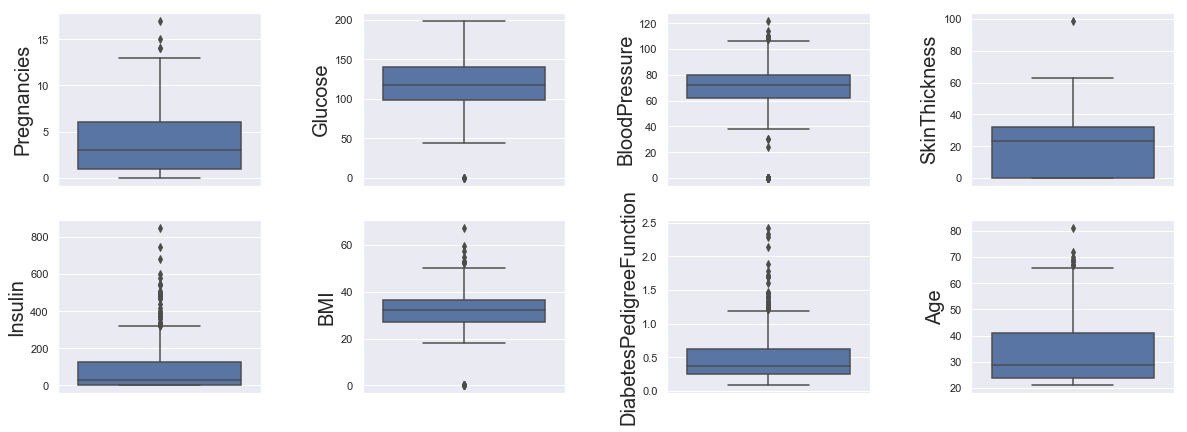

In [159]:
# Boxplot of variables
n_rows = 2
n_cols = 4
count = 0
col_num = 0

# plt.title('Boxplot', size=15)
plt.subplots(n_rows, n_cols,figsize=(20, 7))
plt.subplots_adjust(wspace = 0.5)
for i in range(n_rows):
    for j in range(n_cols):

        plt.subplot(n_rows, n_cols, count+1)
        sns.boxplot(diabetes.drop('Outcome', axis=1).iloc[:, col_num], orient='v') # exclude variable 'Outcome' in boxplot
        plt.ylabel(diabetes.drop('Outcome', axis=1).columns[4*i+j], fontsize=20)
        
        if col_num < (diabetes.drop('Outcome', axis=1).shape[1]-1) :
            count += 1
            col_num += 1
        

# plt.savefig('boxplot.png')

*The boxplot of all variables provides an overview on the dataset. There seems to be some outliers in the variables. Some weird 0, however, may be the reasons and we are going to explore more the value 0 in the following part.*

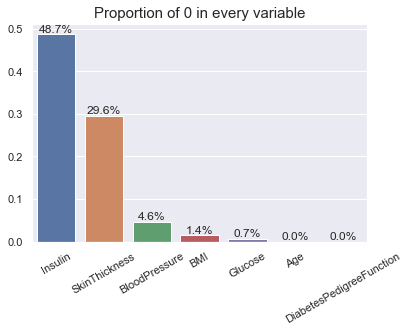

In [165]:
# Number of zero in each variables (except 'Outcome' and 'Pregnancies')
# --------------------------------------------------------------------------------------------------

zero = (diabetes.drop(['Outcome', 'Pregnancies'], axis=1)==0).sum(axis=0) / len(diabetes)
zero = zero.sort_values(ascending=False)

sns.set()
ax = sns.barplot(x=zero.index, y=zero)

def add_value_labels(ax, spacing=0):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1%}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)
plt.xticks(rotation=30)
plt.title('Proportion of 0 in every variable', size=15);

# plt.savefig('zero_proportion.png', bbox_inches='tight')

*Except 'Outcome' and 'Pregnancies', value of the remaining variables (above chart) takes some weird values 0. Among them, nearly half of Insulin and one third of SkinThickness measures are 0, respectively. Obviously, those features can't take value 0 in reality. Therefore, it's necessary to clean those 0 before applying any statistical model.*

### Correlation between 0’s and the outcome variable 

In [125]:
# Table of Outcome vs Insulin
outcome_insulin = pd.crosstab(index = diabetes["Insulin"]==0,
                              columns = diabetes["Outcome"])

outcome_insulin.index = ["Insulin = 0", "Insulin != 0"]
outcome_insulin.columns = ["Diabetes", "Not Diabetes"]



(chi2, p, dof, expected) = chi2_contingency(outcome_insulin)
print('Chi-square statistics is {0:.5f}, p-value is {1:.5f}'.format(chi2, p))

outcome_insulin

Chi-square statistics is 1.12076, p-value is 0.28975


,Diabetes,Not Diabetes
Insulin = 0,264,130
Insulin != 0,236,138


In [126]:
# Table of Outcome vs SkinThickness
outcome_skin = pd.crosstab(index = diabetes["SkinThickness"]==0,
                           columns = diabetes["Outcome"])

outcome_skin.index = ["SkinThickness = 0", "SkinThicknesscies != 0"]
outcome_skin.columns = ["Diabetes", "Not Diabetes"]



(chi2, p, dof, expected) = chi2_contingency(outcome_skin)
print('Chi-square statistics is {0:.5f}, p-value is {1:.5f}'.format(chi2, p))

outcome_skin

Chi-square statistics is 1.89014, p-value is 0.16919


,Diabetes,Not Diabetes
SkinThickness = 0,361,180
SkinThicknesscies != 0,139,88


In [127]:
# Table of Outcome vs BloodPressure
outcome_blood = pd.crosstab(index = diabetes["BloodPressure"]==0,
                           columns = diabetes["Outcome"])

outcome_blood.index = ["BloodPressure = 0", "BloodPressurecies != 0"]
outcome_blood.columns = ["Diabetes", "Not Diabetes"]



(chi2, p, dof, expected) = chi2_contingency(outcome_blood)
print('Chi-square statistics is {0:.5f}, p-value is {1:.5f}'.format(chi2, p))

outcome_blood

Chi-square statistics is 1.42319, p-value is 0.23288


,Diabetes,Not Diabetes
BloodPressure = 0,481,252
BloodPressurecies != 0,19,16


In [128]:
# Table of Outcome vs BMI
outcome_bmi = pd.crosstab(index = diabetes["BMI"]==0,
                           columns = diabetes["Outcome"])

outcome_bmi.index = ["BMI = 0", "BMI != 0"]
outcome_bmi.columns = ["Diabetes", "Not Diabetes"]



(chi2, p, dof, expected) = chi2_contingency(outcome_bmi)
print('Chi-square statistics is {0:.5f}, p-value is {1:.5f}'.format(chi2, p))

outcome_bmi

Chi-square statistics is 0.72737, p-value is 0.39374


,Diabetes,Not Diabetes
BMI = 0,491,266
BMI != 0,9,2


In [129]:
# Table of Outcome vs Glucose
outcome_glucose = pd.crosstab(index = diabetes["Glucose"]==0,
                           columns = diabetes["Outcome"])

outcome_glucose.index = ["Glucose = 0", "Glucose != 0"]
outcome_glucose.columns = ["Diabetes", "Not Diabetes"]



(chi2, p, dof, expected) = chi2_contingency(outcome_glucose)
print('Chi-square statistics is {0:.5f}, p-value is {1:.5f}'.format(chi2, p))

outcome_glucose

Chi-square statistics is 0.05310, p-value is 0.81776


,Diabetes,Not Diabetes
Glucose = 0,497,266
Glucose != 0,3,2


*The correlations between 0’s and the outcome variable are NOT statistically significant, i.e. the value 0 in diagnostic measurements and diabetes are NOT significantly associated.*

### Clean the dataset

In [242]:
# Use KNN to impute missing value

# Define function to impute missing value
def impute_missing(data, k=5):
    
    # Define function to calculate distance between two observations
    def distance(i, j):
        subtract = i - j
        subtract_filer = subtract[subtract.isna()==False] # remove missing value
        euclidean = sum((subtract_filer)**2)**0.5 # calculate euclidean distance

        return euclidean

    
    data = data.copy()
    columns_data_type = data.dtypes # save original data type
    
    # Normalize data, otherwise the different scale unit of variables in the data would impact harmfully the distance measure
    mean_normalize = data.mean()
    std_normalize = data.std()
    data = (data - mean_normalize) / std_normalize
    
    complete_data = data[diabetes.isna().sum(axis=1) == 0].copy() # df has no missing value in every row
    null_data = data[data.isna().sum(axis=1) > 0].copy() # df has at least one missing value in every row
    
    # Impute missing value at every row:
    for i in null_data.index:
        
        dist_to_i = []
        for j in complete_data.index:
            dist_i_j = distance(data.loc[i, :], data.loc[j, :])
            dist_to_i.append(dist_i_j)
            
        dist_to_i = list(zip(complete_data.index, dist_to_i)) # index of row in complete data and its distance to i
        dist_to_i.sort(key = lambda x: x[1]) # sort ascending according to distance to i 
        
        # index of k nearest neighbours
        k_nearest_index = [x[0] for x in dist_to_i[0:k]]
        
        # columns in which missing values of rows i are
        missing_columns = data.columns[data.loc[i, :].isna()]
        
        # Impute missing value by mean of k nearest neighbours
        data.loc[i, missing_columns] = complete_data.loc[k_nearest_index, :].mean(axis=0)[missing_columns]
        
    # Return the original scale
    data = data * std_normalize + mean_normalize
    
    # apply the original datatype
    for i in data.columns:
        data[i] = data[i].astype(columns_data_type[i])
    
    return data


# Define function to estimate execution time of impute_missing()
def estimate_time(data, k=5, n=100):
    
    data_sub = data.iloc[random.sample(range(0, len(data)), min(n, len(data))), :]
    
    starting = datetime.now()
    impute_missing(data_sub, k=k)
    ending = datetime.now()
    
    execution_time_sub = ending - starting
    execution_time = execution_time_sub * ((len(data)/min(100, len(data)))**2)
    
    return(str(execution_time))

In [132]:
diabetes_imputed = impute_missing(data=diabetes)
diabetes_imputed.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,400.2,33.6,0.627,50,1
1,1,85.0,66.0,29.0,65.2,26.6,0.351,31,0
2,8,183.0,64.0,28.8,186.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


### Present dataset on PCA plane

In [137]:
# Assume that all the variables have similar importance.
# As a result, we should scale the data - make the standard deviation of every columns similar.
# (We apply Z-score normalizing, i.e. every columns has mean 0 and standard deviation 1)
# Otherwise, Insulin would be far more important than DiabetesPedigreeFunction just because of different units, for example.

diabetes_imputed_scaled = diabetes_imputed.copy()

columns_mean = diabetes_imputed_scaled.loc[:, diabetes_imputed_scaled.columns != 'Outcome'].mean()
columns_std = diabetes_imputed_scaled.loc[:, diabetes_imputed_scaled.columns != 'Outcome'].std()

diabetes_imputed_scaled.loc[:, diabetes_imputed_scaled.columns != 'Outcome'] = \
    (diabetes_imputed_scaled.loc[:, diabetes_imputed_scaled.columns != 'Outcome'] - columns_mean) / columns_std

diabetes_imputed_scaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639530,0.864081,-0.026705,0.617853,2.553329,0.169454,0.468187,1.425067,1
1,-0.844335,-1.202537,-0.519332,-0.012196,-0.897453,-0.847110,-0.364823,-0.190548,0
2,1.233077,2.012202,-0.683540,-0.033198,0.346889,-1.326347,0.604004,-0.105515,1
3,-0.844335,-1.071324,-0.519332,-0.642245,-0.600789,-0.629275,-0.920163,-1.040871,0
4,-1.141108,0.503243,-2.654046,0.617853,0.161474,1.549075,5.481337,-0.020483,1


The first two components explain 50.8% variation of the data.


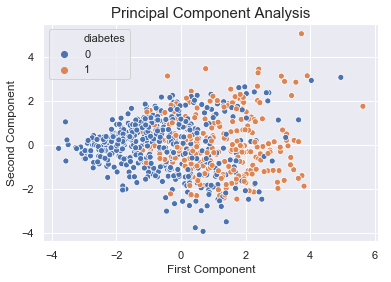

In [260]:
# PCA on scaled data
pca = PCA(n_components=2)

explained_variance = sum(pca.fit(diabetes_imputed_scaled.drop('Outcome', axis=1)).explained_variance_ratio_)
print('The first two components explain {:.1%} variation of the data.'.format(explained_variance))

pca = pca.fit_transform(diabetes_imputed_scaled.drop('Outcome', axis=1))
pca = pd.DataFrame(pca)
pca['Outcome'] = diabetes_imputed_scaled.Outcome
pca.columns = ['first_coordinate', 'second_coordinate', 'diabetes']


sns.scatterplot(x = 'first_coordinate',
                y = 'second_coordinate',
                data = pca,
                hue = 'diabetes')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('Principal Component Analysis', size=15);

# plt.savefig('pca.png', bbox_inches='tight')

*Two groups of observations are fairly well separated on PCA plane eventhough PCA plane explains only 51% variation of data.*

### Unsupervised classification

In [139]:
# K-Means
kmeans = KMeans(n_clusters=2)  
label_kmeans = kmeans.fit_predict(diabetes_imputed_scaled.drop('Outcome', axis=1))

# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
label_hierarchical = hierarchical.fit_predict(diabetes_imputed_scaled.drop('Outcome', axis=1))

# Gaussian Mixture Model
mixture = GaussianMixture(n_components=2)
label_mixture = mixture.fit_predict(diabetes_imputed_scaled.drop('Outcome', axis=1))

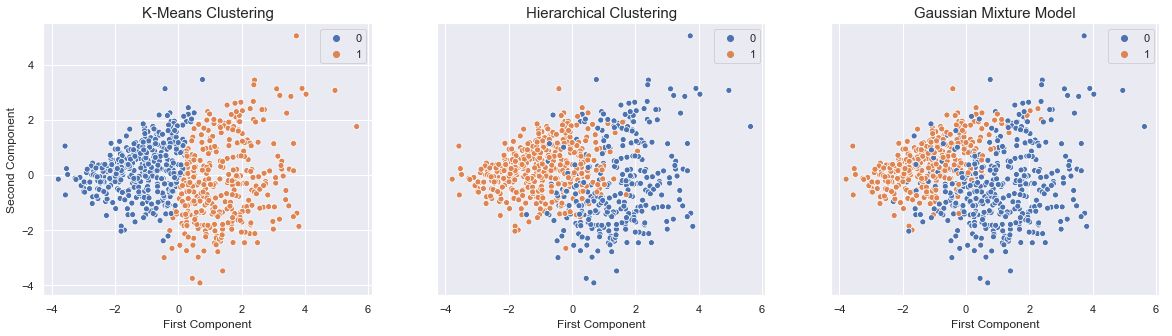

In [261]:
# Scatterplot the three classifications
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x = 'first_coordinate',
                y = 'second_coordinate',
                data = pca,
                hue = label_kmeans)
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('K-Means Clustering', size=15);


plt.subplot(1, 3, 2)
sns.scatterplot(x = 'first_coordinate',
                y = 'second_coordinate',
                data = pca,
                hue = label_hierarchical)
plt.xlabel('First Component')
plt.ylabel(None)
plt.yticks([])
plt.title('Hierarchical Clustering', size=15);


plt.subplot(1, 3, 3)
sns.scatterplot(x = 'first_coordinate',
                y = 'second_coordinate',
                data = pca,
                hue = label_mixture)
plt.xlabel('First Component')
plt.ylabel(None)
plt.yticks([])
plt.title('Gaussian Mixture Model', size=15);

# plt.savefig('clustering.png', bbox_inches='tight')

*As expected, the border between two groups in K-Mean clustering is very hash. Whereas there are some intersection regions at Hierarchical and especially Gaussian Mixture models. Nevertheless, it's hard to say which method is better than the others because (1) the PCA plane explains only 51% of the variance and (2) unsupervised clustering is fairly a subjective task.*

### Supervised classification

In [141]:
# Split into train set and test set
X_train, X_test, y_train, y_test = train_test_split(diabetes_imputed.drop('Outcome', axis=1),
                                                    diabetes_imputed['Outcome'],
                                                    test_size = 0.2,
                                                    random_state = 0)

In [142]:
# Split into train set and test set
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(diabetes_imputed_scaled.drop('Outcome', axis=1),
                                                                                diabetes_imputed_scaled['Outcome'],
                                                                                test_size = 0.2,
                                                                                random_state = 0)

In [299]:
# Logistic regression
logit = LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr')
# use scaled data for logit model, as a result, the fitted coeffcients can be interpreted as the importance features
logit.fit(X_scaled_train, y_scaled_train)
predict_logit = logit.predict(X_scaled_test)

# Support vector machine
svm = SVC(gamma='auto', random_state=0, C=1, kernel='linear')
# use scaled data for SVM, as a result, the fitted coeffcients can be interpreted as the importance features
svm.fit(X_scaled_train, y_scaled_train)
predict_svm = svm.predict(X_scaled_test)

# Random forest
forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_impurity_decrease=5e-3, random_state=0)
forest.fit(X_train, y_train) # there is no need to use scaled data, scaled and non-scaled data will have the same results.
predict_forest = forest.predict(X_test)

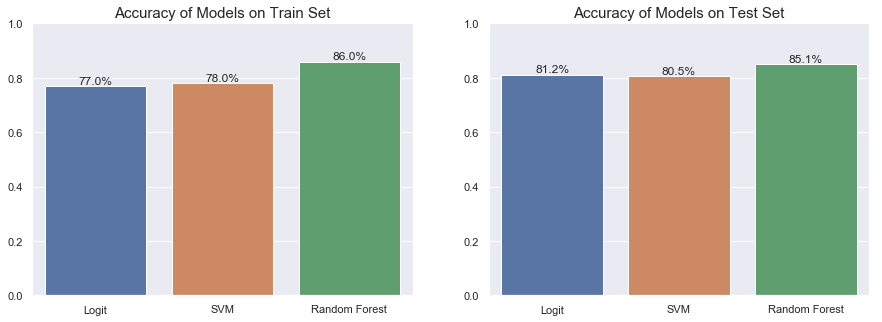

In [301]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
accuracy_logit = sum(logit.predict(X_scaled_train)==y_scaled_train) / len(y_scaled_train)
accuracy_svm = sum(svm.predict(X_scaled_train)==y_scaled_train) / len(y_scaled_train)
accuracy_forest = sum(forest.predict(X_train)==y_train) / len(y_train)

ax = sns.barplot(x=['Logit', 'SVM', 'Random Forest'],
                 y=[accuracy_logit, accuracy_svm, accuracy_forest])
plt.ylim(0,1)
add_value_labels(ax)
plt.title('Accuracy of Models on Train Set', size=15);


plt.subplot(1, 2, 2)
accuracy_logit = sum(predict_logit==y_scaled_test) / len(y_scaled_test)
accuracy_svm = sum(predict_svm==y_scaled_test) / len(y_scaled_test)
accuracy_forest = sum(predict_forest==y_test) / len(y_test)

ax = sns.barplot(x=['Logit', 'SVM', 'Random Forest'],
                 y=[accuracy_logit, accuracy_svm, accuracy_forest])
plt.ylim(0,1)   
add_value_labels(ax)
plt.title('Accuracy of Models on Test Set', size=15);

# plt.savefig('classification.png', bbox_inches='tight')

*Random Forest archives the highest accuracy rate (84.4%) on the testing set. Nevertheless, the other two approaches are not far behind.*

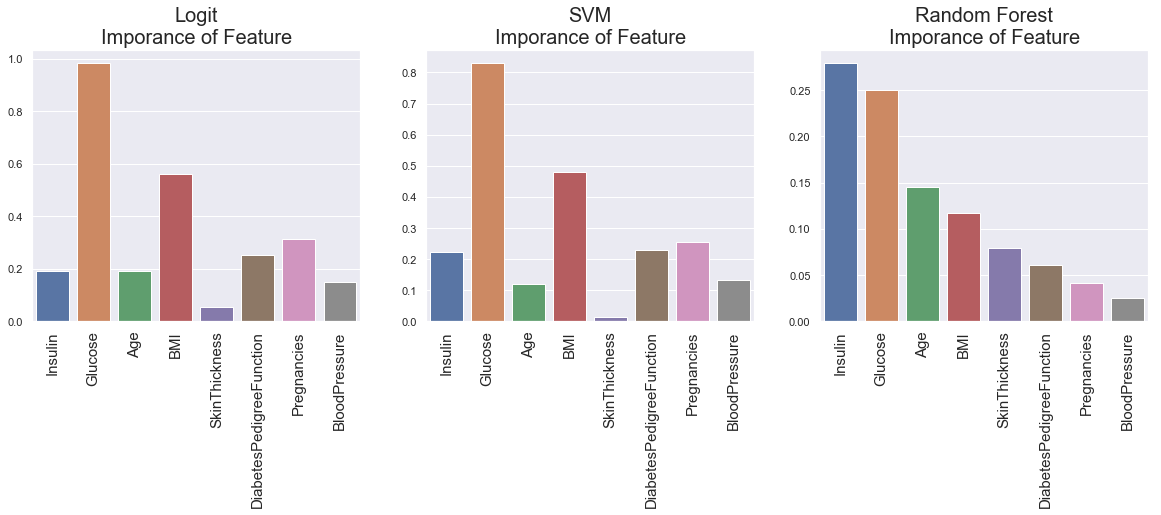

In [309]:
# Meaningful variables 
importance = pd.DataFrame([X_train.columns,
                           abs(logit.coef_[0]), # coefficients of logit model
                           abs(svm.coef_[0]), # coefficients of SVM
                           forest.feature_importances_]).transpose() # feature importance in random forest

importance.columns = ['Variable', 'Logit', 'SVM', 'Random Forest']
importance.sort_values('Random Forest', ascending=False, inplace=True)

# Plot the feature importances of the forest
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.barplot(x='Variable',
            y='Logit',
            data=importance)

plt.xticks(rotation=90, size=15)
plt.xlabel(None)
plt.ylabel(None)
plt.title('Logit\nImporance of Feature', size=20);


plt.subplot(1, 3, 2)
sns.barplot(x='Variable',
            y='SVM',
            data=importance)

plt.xticks(rotation=90, size=15)
plt.xlabel(None)
plt.ylabel(None)
plt.title('SVM\nImporance of Feature', size=20);


plt.subplot(1, 3, 3)
sns.barplot(x='Variable',
            y='Random Forest',
            data=importance)

plt.xticks(rotation=90, size=15)
plt.xlabel(None)
plt.ylabel(None)
plt.title('Random Forest\nImporance of Feature', size=20);

# plt.savefig('feature_importance.png', bbox_inches='tight')

*As the data used in Logit and SVM is normalized, i.e. the standard deviation of every column is equal, the absolute value of coefficients of those models can be interpreted as importance level. Importance of feature in Random Forest model, on the other hand, is calculated by how much GINI index can be improved using each variable. As a result, Glucose and BMI (and Insulin according to Random Forest) are the most importance metrics to distinguish the Outcome.*